In [1]:
import polars
import pandas as pd
import pathlib
import numpy as np
import scipy
import scanpy as sc
import matplotlib.pyplot as plt
import sklearn.manifold

import preprocessing
import plots

## Identify subset of variables of interest (protein coding genes)

In [2]:
preprocessing.get_protein_coding_genes(
    file_path='../data/gencode.v26.annotation.gtf.gz', 
    save_path='../results/protein_coding_genes.csv',
    overwrite=True
)

Loading gencode file with gene metadata...
19817 protein coding genes found. Saving to ../results/protein_coding_genes.csv.


## Identify subset of samples of interest (selected tissues)

In [3]:
sample_df_columns_description = pd.read_excel('../data/GTEx_Analysis_v8_Annotations_SampleAttributesDD.xlsx')
print(sample_df_columns_description[['VARNAME','COMMENT2']].to_string())

      VARNAME                                                                                                               COMMENT2
0      SAMPID                                                                                                                    NaN
1    SMATSSCR                               The destruction of organism cells or tissues by the organisms’ own enzymes or processes.
2    SMNABTCH                                                            Batch when DNA/RNA was isolated and extracted from a sample
3   SMNABTCHT                                                                              The process by which DNA/RNA was isolated
4   SMNABTCHD                                                                                 The date on which DNA/RNA was isolated
5    SMGEBTCH                                                                          Batch when DNA/RNA from a sample was analyzed
6   SMGEBTCHD                                                        

SMTSD
Heart - Atrial Appendage    429
Heart - Left Ventricle      432
Kidney - Cortex              85
Kidney - Medulla              4
Liver                       226
Lung                        578
Muscle - Skeletal           803
Pancreas                    328
Pituitary                   283
Spleen                      241
Stomach                     359
Thyroid                     653
Name: count, dtype: int64

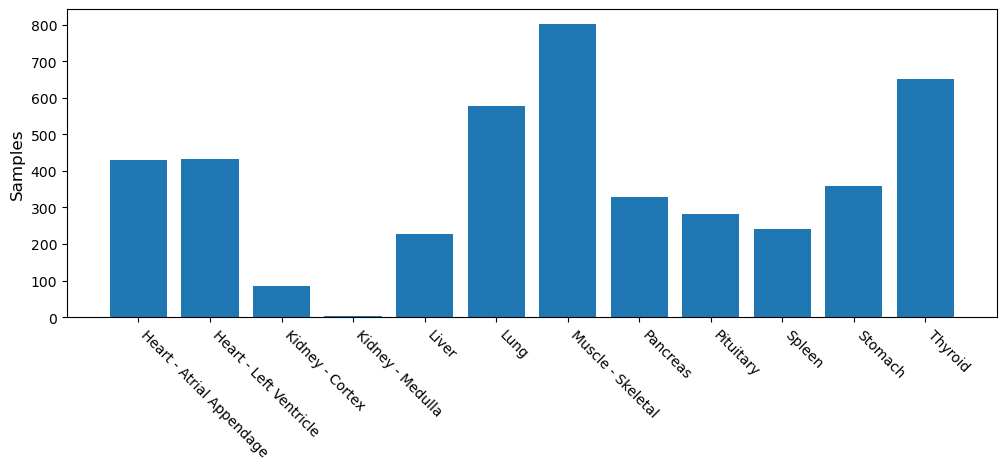

In [4]:
# load metadata
sample_df = pd.read_csv('../data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt', sep='\t', index_col=0)
subject_df = pd.read_csv('../data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt', sep='\t', index_col=0)

# subset to RNA-seq 
selected_tissues = ['heart', 'kidney', 'liver', 'lung', 'muscle', 'pancreas', 'spleen', 'stomach', 'pituitary', 'thyroid']
rnaseq_sample_df = sample_df[sample_df['SMAFRZE']=='RNASEQ']

# subset RNA-seq to tissues of interest
selected_tissues_idx = rnaseq_sample_df['SMTSD'].str.contains('|'.join(selected_tissues),case=False)
rnaseq_sample_selected_tissues_df = rnaseq_sample_df[selected_tissues_idx].copy()

# add extra patient metadata columns and save
rnaseq_sample_selected_tissues_df['donor_ids'] = rnaseq_sample_selected_tissues_df.index.map(lambda x: '-'.join(x.split('-')[:2]))
df_ = rnaseq_sample_selected_tissues_df[['donor_ids']].reset_index().set_index('donor_ids').join(subject_df).set_index('SAMPID')
rnaseq_sample_selected_tissues_df = rnaseq_sample_selected_tissues_df.join(df_)

# grouping kidney tissue annotation (justified based on MDS plot analysis hereafter)
rnaseq_sample_selected_tissues_df['SMTSD_grouped'] = rnaseq_sample_selected_tissues_df['SMTSD']
rnaseq_sample_selected_tissues_df.loc[sample_df['SMTSD'].str.contains('Kidney'),'SMTSD_grouped'] = 'Kidney'

# save
rnaseq_sample_selected_tissues_df.to_csv('../results/rnaseq_sample_selected_tissues_metadata.csv')

# plot subsetting results
sample_size_df = rnaseq_sample_selected_tissues_df['SMTSD'].value_counts().sort_index()
display(sample_size_df)
plots.barplot(sample_size_df,save_path="../figures/number_of_samples_barplot.png",figsize=(12,4))

In [ ]:
plots.barplot(sample_size_df,save_path=None,figsize=(12,4))

## Load data subset of interest

In [5]:
overwrite = True

if overwrite or not pathlib.Path('../results/rnaseq_sample_selected_tissues.mm').is_file():

    # subset of interest
    protein_coding_genes = pd.read_csv('../results/protein_coding_genes.csv')
    rnaseq_sample_selected_tissues_ids = pd.read_csv('../results/rnaseq_sample_selected_tissues_metadata.csv',index_col=0).index

    print('Reading gene expression')
    df = polars.read_csv('../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz', separator='\t', skip_rows=2,
                        columns= ['Name','Description'] + rnaseq_sample_selected_tissues_ids.to_list(), 
    )
    df_tpm = polars.read_csv('../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', separator='\t', skip_rows=2,
                        columns= ['Name','Description'] + rnaseq_sample_selected_tissues_ids.to_list(), 
    )

    print('Subset to protein coding')
    df_protein_coding = df.filter(df['Name'].is_in(protein_coding_genes['gene_id']))
    df_protein_coding_tpm = df_tpm.filter(df_tpm['Name'].is_in(protein_coding_genes['gene_id']))
    print(len(df_protein_coding), 'protein coding genes found out of ', len(protein_coding_genes))

    # save in R and Python compatible sparse format
    print('Saving as sparse...')
    X = scipy.sparse.csr_matrix(df_protein_coding[:,2:].to_numpy())
    X_tpm = scipy.sparse.csr_matrix(df_protein_coding_tpm[:,2:].to_numpy())
    scipy.io.mmwrite('../results/rnaseq_sample_selected_tissues.mm',X)
    scipy.io.mmwrite('../results/rnaseq_sample_selected_tissues_tpm.mm',X)
    df_protein_coding[['Description','Name']].write_csv('../results/rnaseq_sample_selected_tissues_genes_rows.csv')
    pd.DataFrame(df_protein_coding.columns[2:]).to_csv('../results/rnaseq_sample_selected_tissues_samples_columns.csv')
    print('Done')

# save as anndata
# if not pathlib.Path('../results/rnaseq_sample_selected_tissues.h5ad').ispath():
#     adata = sc.AnnData(X.T)
#     adata.obs_names = df.columns[2:]
#     adata.var_names = df['Name'].to_numpy().squeeze()
#     adata.var['Description'] = df['Description'].to_numpy().squeeze()
#     adata.write('../results/rnaseq_sample_selected_tissues.h5ad')

Reading gene expression
Subset to protein coding
19291 protein coding genes found out of  19817
Saving as sparse...
Done


In [5]:
# We first grouped samples based on GTEx-annotated subregions (labeled SMTS) by taking, for example, all skin-derived samples. 
# We excluded the X, Y, and mitochondrial genes, identified the 1000 most variable autosomal genes, 
# and performed PCoA using Euclidean distance on the log2-transformed raw count expression data

adata = preprocessing.load_rnaseq_sample_selected_tissues_anndata(
     X_path="../results/rnaseq_sample_selected_tissues.mm",
     genes_rows_path="../results/rnaseq_sample_selected_tissues_genes_rows.csv",
     samples_columns_path="../results/rnaseq_sample_selected_tissues_samples_columns.csv",
     samples_metadata_path="../results/rnaseq_sample_selected_tissues_metadata.csv",
)
protein_coding_genes = pd.read_csv('../results/protein_coding_genes.csv',index_col=0)

protein_coding_genes_subset = protein_coding_genes[
    ~( protein_coding_genes['0'].isin(['chrX','chrY']) | 
   protein_coding_genes['gene_name'].str.contains('MT-'))
]

In [21]:
protein_coding_genes_subset = protein_coding_genes[
    ~( protein_coding_genes['0'].isin(['chrX','chrY']) | 
   protein_coding_genes['gene_name'].str.contains('MT-'))
]

Kidney


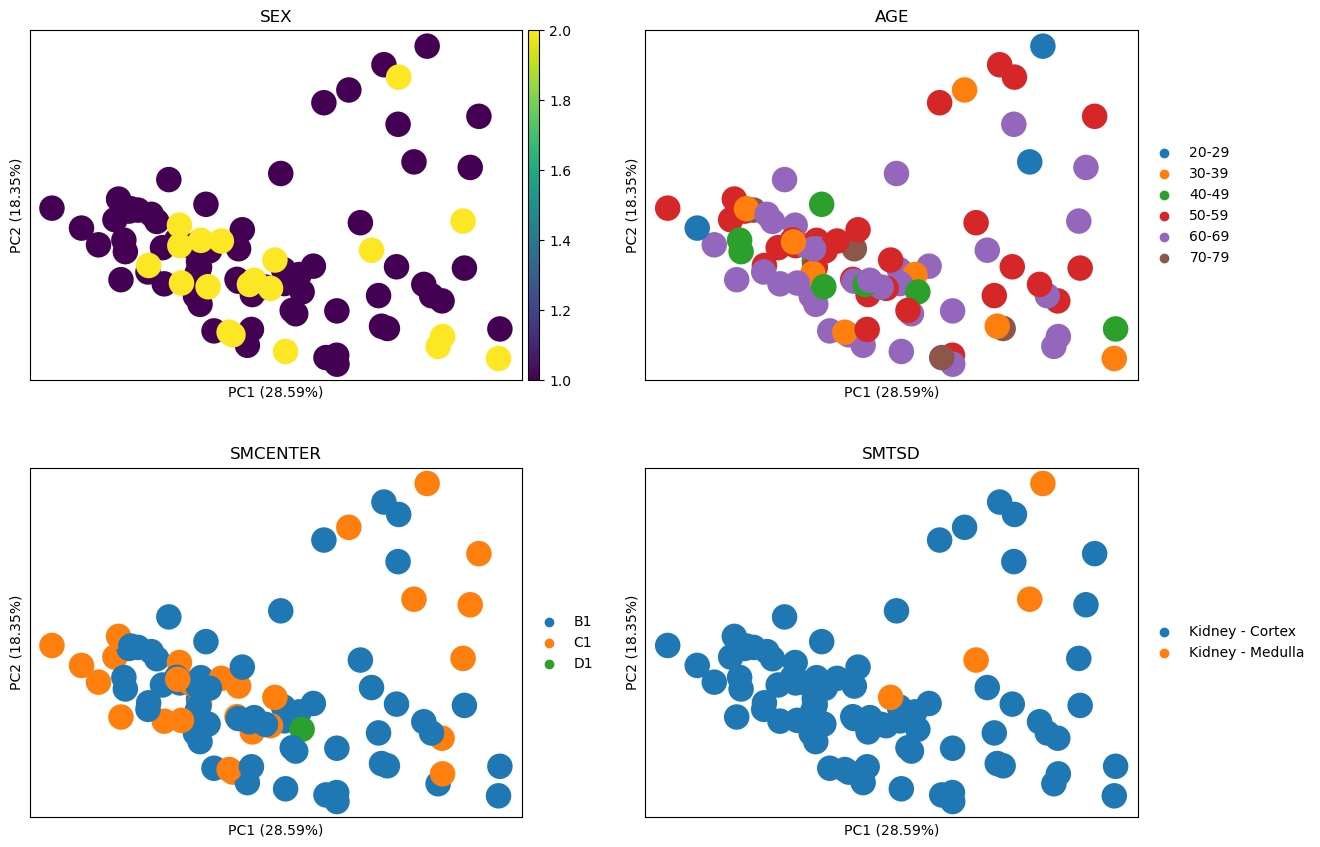

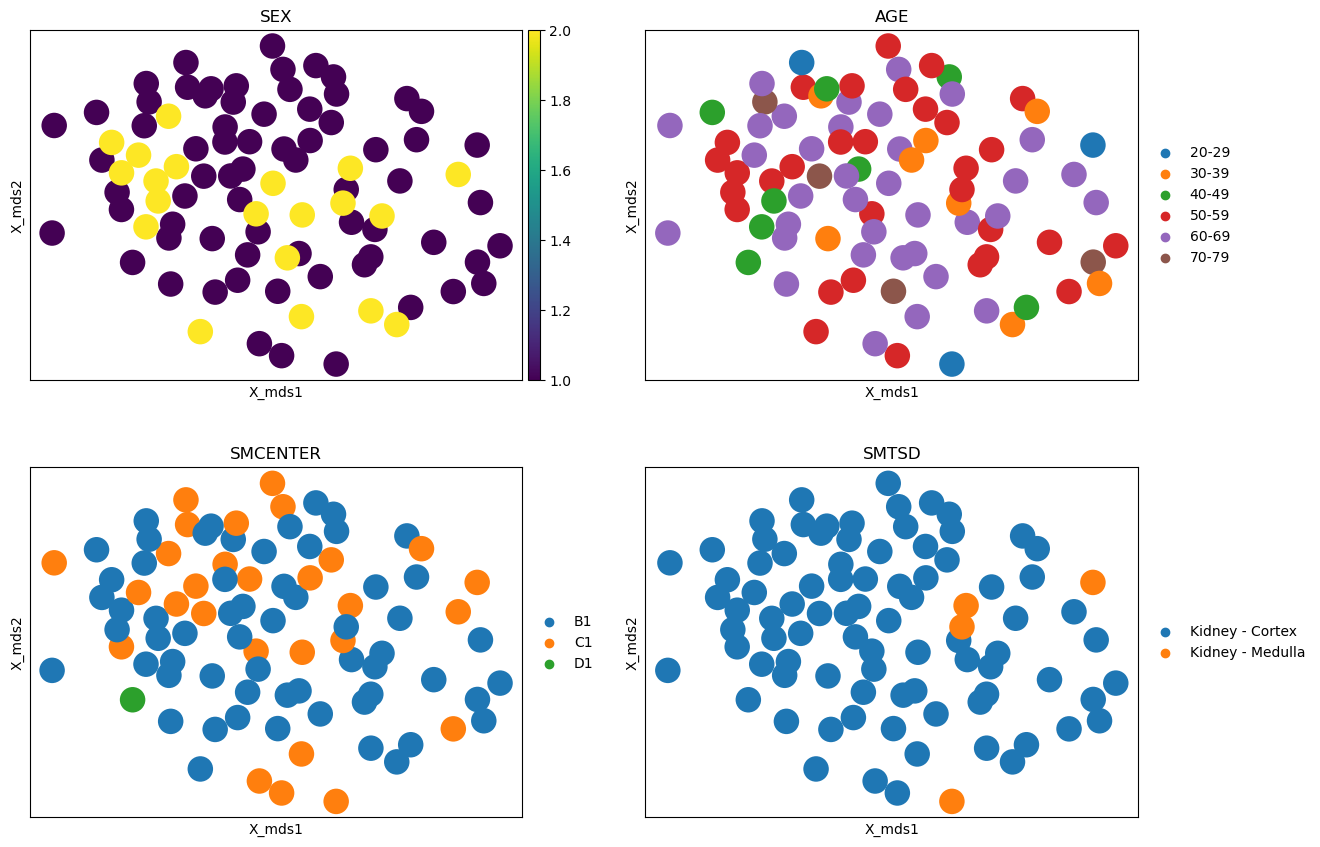

Heart


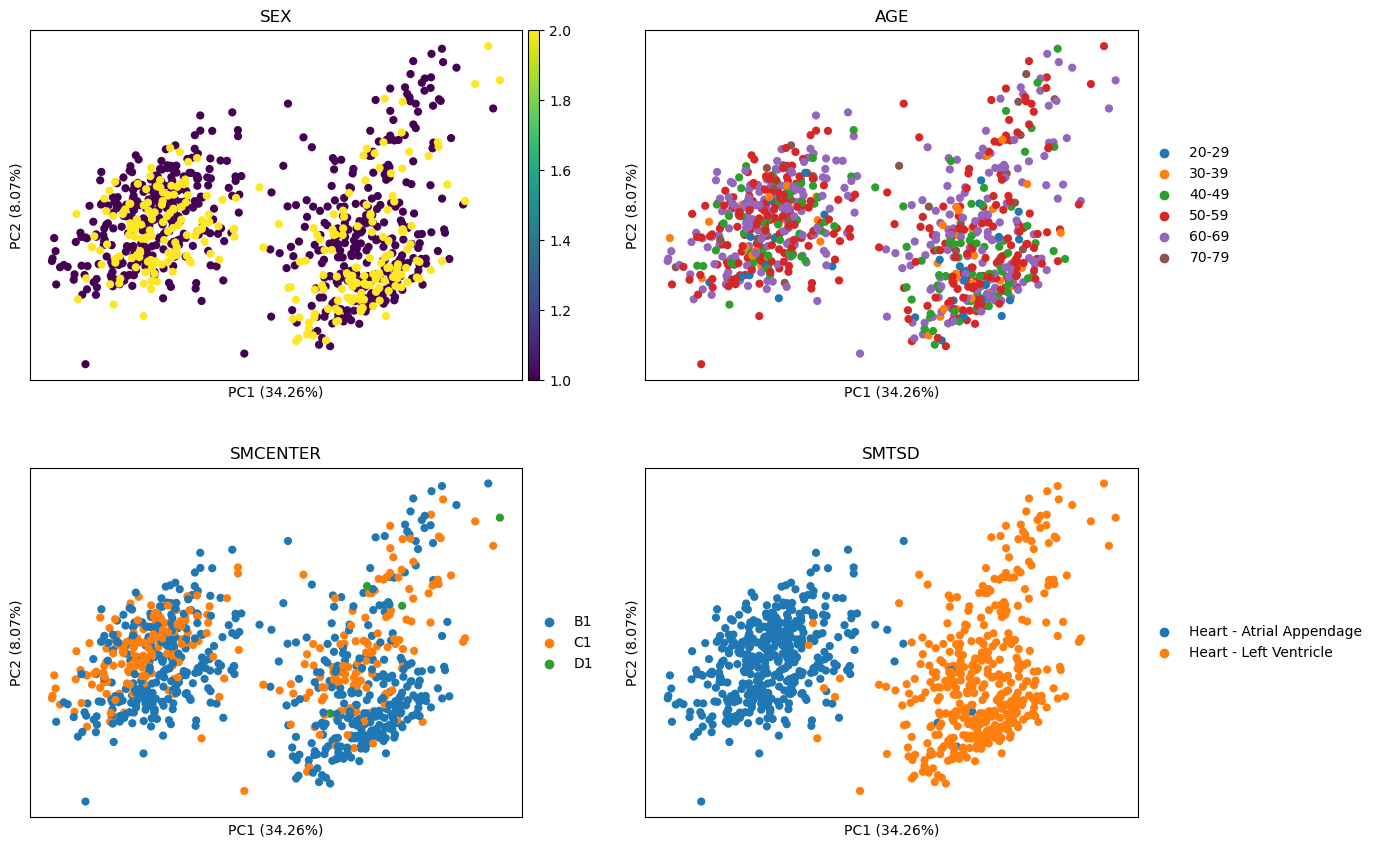

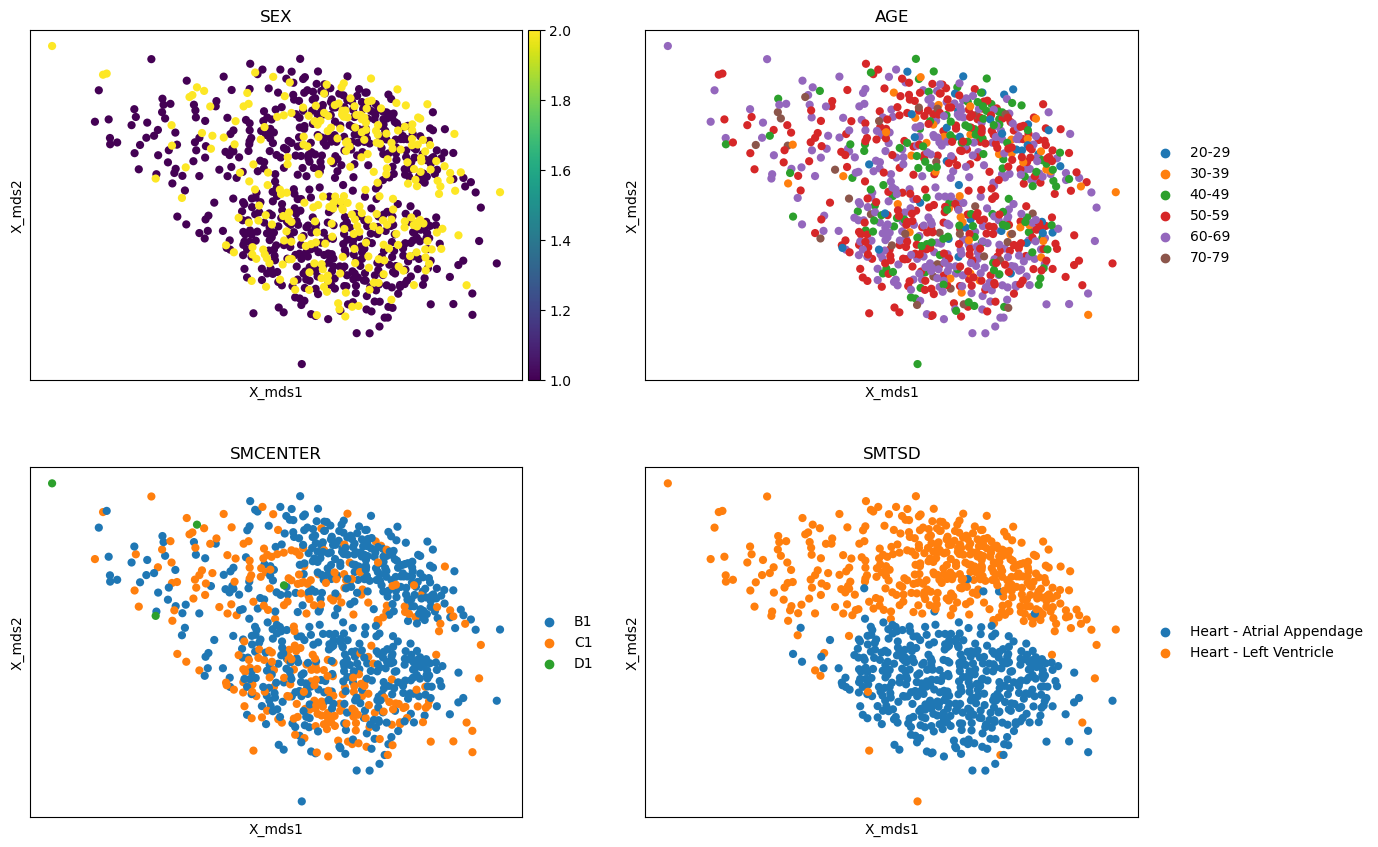

In [59]:
for tissue in ['Kidney','Heart']:
    print(tissue)

    tissue_idx = adata.obs['SMTSD'].str.contains(tissue)
    genes_idx = [gene for gene in protein_coding_genes_subset['gene_id'].values if gene in adata.var_names]
    adata_tissue = adata[tissue_idx,genes_idx].copy()

    sc.pp.highly_variable_genes(adata_tissue,n_top_genes=1000,flavor='seurat_v3')
    sc.pp.log1p(adata_tissue)
    sc.pp.pca(adata_tissue)
    adata_tissue.obsm['X_mds'] = sklearn.manifold.MDS(verbose=1, n_jobs=4).fit_transform(adata_tissue.X.A)


    sc.settings.figdir=pathlib.Path('../figures')
    sc.pl.pca(adata_tissue,color=['SEX','AGE','SMCENTER','SMTSD'],annotate_var_explained=True,ncols=2,save=f'{tissue}_PCA.png')
    sc.pl.embedding(adata_tissue,'X_mds',color=['SEX','AGE','SMCENTER','SMTSD'],ncols=2,save=f'{tissue}_MDS.png')